In [1]:
import sys
import os
path_to_add = os.getcwd()+"/../filter_masks"
sys.path.append(path_to_add)
from pylab import *
import h5py
from scipy.optimize import curve_fit
#from scipy.stats import binned_statistic_dd
from scipy.stats import binned_statistic_dd
import filter_masks
import pickle
from scipy import stats
from scipy.stats.mstats import theilslopes
from scipy.signal import medfilt
from cycler import cycler
from scipy.signal import savgol_filter
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib import interactive
import scipy.ndimage
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
#default plot setting
mpl.rcParams['axes.prop_cycle'] = cycler(color='brgcmyk')
mpl.rcParams['figure.figsize'] = (8,8)
plt.rcParams['image.cmap'] = 'magma'
#mpl.rcParams['text.usetex'] = True
#mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['font.serif'] = 'Computer Modern Roman'
#mpl.rcParams['lines.linewidth'] = 1.5
mpl.rcParams['font.size'] = 18
mpl.rcParams['legend.fontsize'] = 10


#load data
experiment_run_name = "sxri0414run60"
my_file = experiment_run_name+".h5"
my_hdf5_object = h5py.File("../small_h5_data/"+my_file,"r")

#convert hdf5 to dict
my_list = []
def func(name, obj):
    my_list.append(name)

my_hdf5_object.visititems(func)
my_dict = {}
for i in my_list:
    my_dict[i] = array(my_hdf5_object[i])
pixel_to_femtosecond_list = []
width_list = []

#no built in type for weighted binnsed statistic, 
#might be able to use sum instead of mean (or average)
def weighted_binned_statistic(x,y,weights,bins,statistic):
    binned_weighted_statistic = binned_statistic_dd(x,y*weights,bins=[my_bins],statistic=average)
    binned_weights = binned_statistic_dd(x,1.0*weights,bins=[my_bins],statistic=average)
    
    return  binned_weighted_statistic.statistic/binned_weights.statistic

#make mask
my_mask =  filter_masks.__dict__[experiment_run_name](my_dict)
my_mask *=  (my_dict['timeToolOpal/time_pixel']>300)
my_mask *=  (my_dict['timeToolOpal/time_pixel']<1600)
#my_mask *=  (my_dict['ebeam/photon_energy']>913.75)
#my_mask *=  (my_dict['ebeam/photon_energy']<914.25)

#my_mask *=  (my_dict['timeToolOpal/uncertainty_cov']*pixel_to_femtosecond<0.0002)

/reg/data/ana13/sxr/sxri0414/res/automated_analysis/for_pub/../filter_masks/filter_masks.py:14: RuntimeWarning: invalid value encountered in greater
  myMask = myMask * (array(myDict['gas_detector/f_11_ENRC'])>1)


In [3]:
#viewing  IvsI0 as function of energy (i.e. photon wavelength).  Are small wavelength fluctuations kill swamping the signal?
x = my_dict['GMD'][my_mask]
y = my_dict['acqiris2/amplitude'][my_mask]
sy = my_dict['acqiris2/uncertainty_cov'][my_mask]
energy = my_dict['ebeam/photon_energy'][my_mask]
fee = my_dict['gas_detector/f_22_ENRC'][my_mask]

fee_difr = my_dict['gas_detector/f_12_ENRC'][my_mask]

my_bins = arange(900,935,0.2)

#defining truncated mean
def quartile_mean(x):
    return stats.trim_mean(x, 0.25)

In [4]:
#generate reference curve
IvsFEE_average = binned_statistic_dd(energy,y,bins=[my_bins],statistic=average).statistic
I0vsFEE_average = binned_statistic_dd(energy,x,bins=[my_bins],statistic=average).statistic

In [5]:
#showing I and I0 are shifted with respect to each other.
def gaussian(x, x0,sigma,a):
        
    #return a*exp(-(x-x0)**2/(2*sigma**2))+4e-2
    return a*exp(-(x-x0)**2/(2*sigma**2))
    
#plot(my_bins[:-1],IvsFEE_average)
popt, pcov = curve_fit(gaussian, my_bins[:-1][45:123],IvsFEE_average[45:123],p0=[914,5,1])

#plot(my_bins[:-1],gaussian(my_bins[:-1],popt[0],popt[1],popt[2]))
#twinx()

def gaussian_gmd(x, x0,sigma,a):
        
    #return a*exp(-(x-x0)**2/(2*sigma**2))+0.7e-4
    return a*exp(-(x-x0)**2/(2*sigma**2))

#plot(my_bins[:-1],I0vsFEE_average,'r')
popt, pcov = curve_fit(gaussian_gmd, my_bins[:-1][45:123],I0vsFEE_average[45:123],p0=[914,5,.0014])

#plot(my_bins[:-1],gaussian_gmd(my_bins[:-1],popt[0],popt[1],popt[2]),c='purple')
#ylim(-0.0000,0.00088)
#show()

In [6]:
#increment over fee value and generate I and I0 vs photon wavelength
#GMD_spectra_stack = []
#acq_spectra_stack = []

acq_spectra_amplitude = []
GMD_spectra_amplitude = []



fee_bin_size = .02
fee_bins = arange(0.30,0.7,fee_bin_size)
for i in fee_bins:
    
    fee_mask = ones(len(x)).astype(bool)
    fee_mask *= fee>i
    fee_mask *= fee<i+fee_bin_size
    
    popt = energy[fee_mask],y[fee_mask]
    popt, pcov = curve_fit(gaussian,energy[fee_mask],y[fee_mask],p0=[914,5,1])
    acq_spectra_amplitude.append(popt)
    
    popt, pcov = curve_fit(gaussian_gmd,energy[fee_mask],x[fee_mask],p0=[914,5,.0014])
    GMD_spectra_amplitude.append(popt)
    
    
#increment over fee value and generate I and I0 vs photon wavelength
#GMD_spectra_stack = []
#acq_spectra_stack = []

fee_bin_size = .05
fee_bins2 = arange(1.0,1.8,fee_bin_size)
for i in fee_bins2:
    
    fee_mask = ones(len(x)).astype(bool)
    fee_mask *= fee_difr>i
    fee_mask *= fee_difr<i+fee_bin_size
    
    popt = energy[fee_mask],y[fee_mask]
    popt, pcov = curve_fit(gaussian,energy[fee_mask],y[fee_mask],p0=[914,5,1])
    acq_spectra_amplitude.append(popt)
    
    popt, pcov = curve_fit(gaussian_gmd,energy[fee_mask],x[fee_mask],p0=[914,5,.0014])
    GMD_spectra_amplitude.append(popt)
    
fee_bins = append(fee_bins,fee_bins2)
my_slope = theilslopes(abs(array(acq_spectra_amplitude)).transpose()[2],abs(array(GMD_spectra_amplitude).transpose()[2]),alpha=0.95)


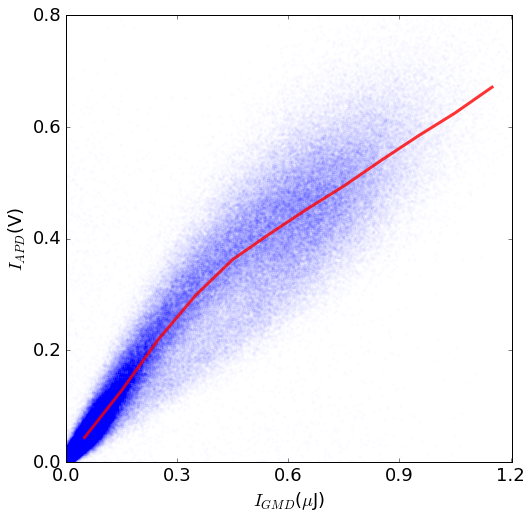

In [7]:
#this show the relationship between I and I0 is more linear after accoutning for different photon energy responses in 
#I and I0
f5, axarr5 = plt.subplots(1, sharex=True)
axarr5.plot(my_dict['GMD'],my_dict['acqiris2/amplitude'],'.',alpha=0.006,markersize=6.0)
#axarr5.plot(array(GMD_spectra_amplitude).transpose()[2],array(acq_spectra_amplitude).transpose()[2],'ro',alpha=50)
my_slope= theilslopes(array(acq_spectra_amplitude).transpose()[2],array(GMD_spectra_amplitude).transpose()[2],alpha=0.95)
#axarr5.plot(arange(0,0.0015,.0001),my_slope[0]*arange(0,0.0015,.0001)+my_slope[1],'r-',linewidth=2,alpha=50)

my_hist = binned_statistic_dd(x,y,bins=[arange(0,0.0014,0.0001)],statistic=median).statistic
axarr5.plot((arange(0,0.0014,0.0001)[1:]+arange(0,0.0014,0.0001)[:-1])/2,my_hist,linewidth=3,alpha=.80,c='r',linestyle='solid')

#I_FEE_hist = binned_statistic_dd(fee,y,bins=[arange(0.05,0.85,0.02)],statistic=mean).statistic
#I0_FEE_hist = binned_statistic_dd(fee,x,bins=[arange(.05,0.85,0.02)],statistic='mean').statistic
#plot(I0_FEE_hist,I_FEE_hist,marker='o',color='purple',linewidth=0)

axarr5.set_xlim(0.000,0.001205)
axarr5.set_xticks(arange(0,.001205,.0003))
axarr5.set_xticklabels(["0.0","0.3","0.6","0.9","1.2"])
axarr5.set_ylim(0,0.8)
axarr5.set_yticks(arange(0,.805,.2))
#axarr5.set_xlabel("I$_0$(mV)")
axarr5.set_xlabel(r"$I_{GMD}$($\mu$J)")
axarr5.set_ylabel("$I_{APD}$(V)")
show()

In [26]:
energy_x_product = (energy-mean(energy))*(x-mean(x))
fee_energy_gmd_product = (fee-mean(fee))*(x-mean(x))*(energy-mean(energy))
temp_array = array([ones(len(x)),x,energy,energy_x_product]).transpose()
pseudo_inv = dot(inv(dot(temp_array.transpose(),temp_array)),array(temp_array).transpose())
beta = dot(pseudo_inv,y-mean(y))

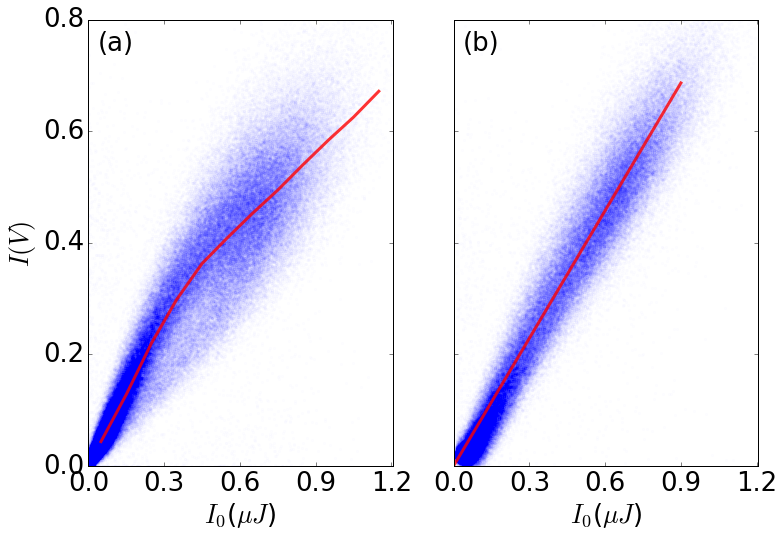

In [27]:
mpl.rcParams['figure.figsize'] = (12,8)
mpl.rcParams['font.size'] = 26
mpl.rcParams['legend.fontsize'] = 16
x = my_dict['GMD'][my_mask]

x_label_offset = 0.15
y_label_offset = 0.925

#y = my_dict['acqiris2/amplitude'][my_mask]
#sy = my_dict['acqiris2/uncertainty_cov'][my_mask]
#energy = my_dict['ebeam/photon_energy'][my_mask]
#fee = my_dict['gas_detector/f_22_ENRC'][my_mask]

#y_corrected = y-dot(temp_array[:,2:],beta[2:])-temp_array[:,0]*beta[0]-mean(y)
y_corrected = y-dot(temp_array[:,2:4]-mean(temp_array[:,2:4],axis=0),beta[2:])

f5, axarr5 = plt.subplots(1,2,sharey=True)
axarr5[1].plot(x,y_corrected,'.',alpha=0.006,markersize=6.0)

x_linear = arange(0,0.001,0.0001)
axarr5[1].plot(x_linear,(x_linear)*beta[1],linewidth=3,alpha=.80,c='r',linestyle='solid')
axarr5[1].set_xlim(0.000,0.001205)
axarr5[1].set_ylim(0,max(y_corrected))


axarr5[0].plot(my_dict['GMD'],my_dict['acqiris2/amplitude'],'.',alpha=0.006,markersize=6.0)
#axarr5.plot(array(GMD_spectra_amplitude).transpose()[2],array(acq_spectra_amplitude).transpose()[2],'ro',alpha=50)
my_slope= theilslopes(array(acq_spectra_amplitude).transpose()[2],array(GMD_spectra_amplitude).transpose()[2],alpha=0.95)
#axarr5.plot(arange(0,0.0015,.0001),my_slope[0]*arange(0,0.0015,.0001)+my_slope[1],'r-',linewidth=2,alpha=50)

my_hist = binned_statistic_dd(x,y,bins=[arange(0,0.0014,0.0001)],statistic=median).statistic
axarr5[0].plot((arange(0,0.0014,0.0001)[1:]+arange(0,0.0014,0.0001)[:-1])/2,my_hist,linewidth=3,alpha=.80,c='r',linestyle='solid')
axarr5[0].text(x_label_offset, 0.975, "(a)", transform=axarr5[0].transAxes,fontsize=26, fontweight='normal', va='top', ha='right')
axarr5[1].text(x_label_offset, 0.975, "(b)", transform=axarr5[1].transAxes,fontsize=26, fontweight='normal', va='top', ha='right')

for i in range(2):
    axarr5[i].set_xlim(0.000,0.001205)
    axarr5[i].set_xticks(arange(0,.001205,.0003))
    axarr5[i].set_xticklabels(["0.0","0.3","0.6","0.9","1.2"])
    axarr5[i].set_xlabel(r"$I_{0}$($\mu J$)")

axarr5[0].set_ylim(0,0.8)
axarr5[0].set_yticks(arange(0,.805,.2))
#axarr5.set_xlabel("I$_0$(mV)")
axarr5[0].set_ylabel(r"$I(V)$")

show()

mpl.rcParams['figure.figsize'] = (8,8)
mpl.rcParams['font.size'] = 18
mpl.rcParams['legend.fontsize'] = 10

In [36]:
y_corrected.shape

(173425,)

In [37]:
y_bins = arange(0,.8,0.02)
x_bins = arange(0,0.001,0.00002)
IvsI0_hist = binned_statistic_dd([y,x],1,bins=[y_bins,x_bins],statistic='count')
my_hist = binned_statistic_dd(x,y,bins=[arange(0,0.0011,0.00005)],statistic=median).statistic

In [38]:
def make_IvsI0(fee_start,fee_stop,start_range,stop_range):
    #start_range = 45
    #stop_range = 85
    fee_mask = ones(len(x)).astype(bool)
    fee_mask *= fee>fee_start
    fee_mask *= fee<fee_stop
    IvsFEE_average = binned_statistic_dd(energy[fee_mask],y[fee_mask],bins=[my_bins],statistic=average).statistic
    I0vsFEE_average = binned_statistic_dd(energy[fee_mask],x[fee_mask],bins=[my_bins],statistic=average).statistic
    return IvsFEE_average[start_range:-stop_range],I0vsFEE_average[start_range:-stop_range],my_bins[start_range:-stop_range]+mean(diff(my_bins))/2.0

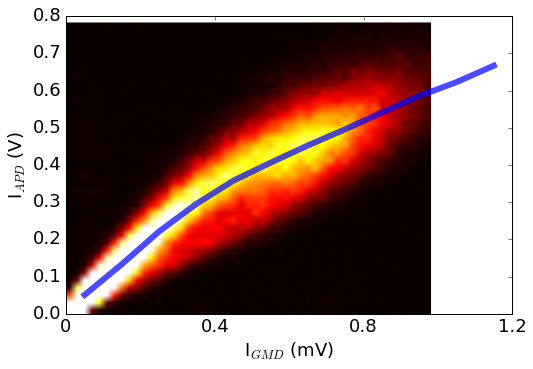

In [39]:
f2, axarr2 = plt.subplots(1, sharex=True)
axarr2.imshow((IvsI0_hist[0][::-1,:]+1),cmap='hot',interpolation='bilinear',clim=(0,400),extent=(0,max(x_bins),0,max(y_bins)),aspect=1.0/1e3)
axarr2.set_ylabel("I$_{APD}$ (V)")
axarr2.set_xlabel("I$_{GMD}}$ (mV)")

my_hist = binned_statistic_dd(x,y,bins=[arange(0,0.0014,0.0001)],statistic=mean).statistic
axarr2.plot((arange(0,0.0014,0.0001)[1:]+arange(0,0.0014,0.0001)[:-1])/2,my_hist,linewidth=6,alpha=0.7)
#plot(array(GMD_spectra_amplitude).transpose()[2],array(acq_spectra_amplitude).transpose()[2],'go')

#plot(arange(0,0.0011,0.00005)[:-1],my_hist,'b-',marker='o',linewidth=1)
axarr2.set_xlim(0,0.0012)
axarr2.set_xticks(arange(0,0.0014,0.0004))
axarr2.set_xticklabels(["0","0.4","0.8","1.2"])

#xlabel()
show()


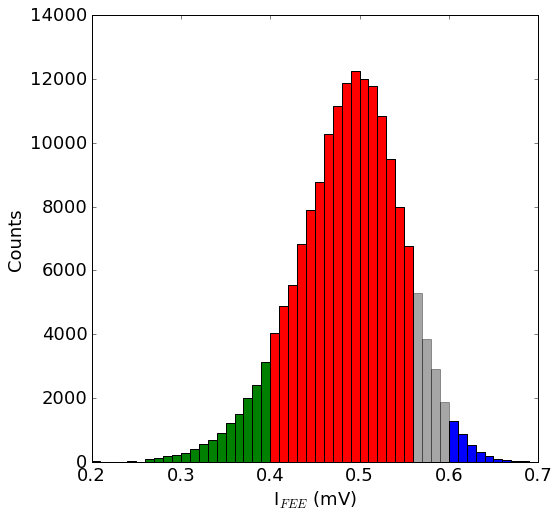

In [40]:
f6, axarr6 = plt.subplots(1, sharex=True)
axarr6.hist(fee,bins=arange(0.2,0.7,0.01),color='k',alpha=0.35)
axarr6.set_ylabel("Counts")
axarr6.set_xlabel("I$_{FEE}$ (mV)")

for i in [[.60,1],[.4,.56],[.0,.4]]:
    color_fee_mask = fee > i[0]
    color_fee_mask *= fee < i[1]
    axarr6.hist(fee[color_fee_mask],bins=arange(0.2,0.7,0.01),alpha=1)

show()

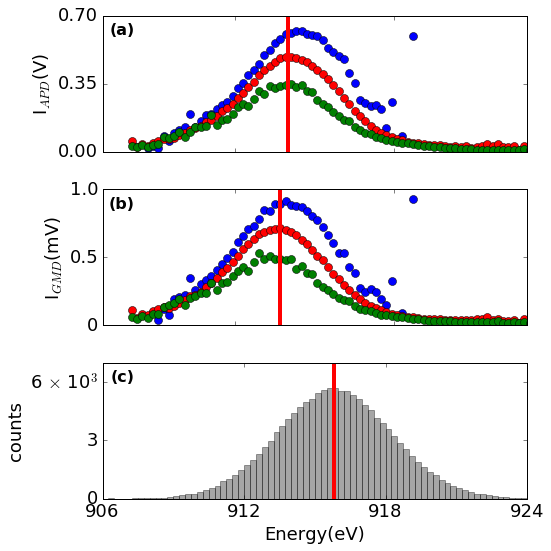

In [41]:
#fee weighted energy histogram
f, axarr = plt.subplots(3, sharex=True)

for i in [[.60,1],[.4,.56],[.0,.4]]:
    IvsFEE_average,I0vsFEE_average,e_bins = make_IvsI0(i[0],i[1],40,50)
    IvsE_moment = mean(nan_to_num(IvsFEE_average*e_bins[:-1]))/mean(nan_to_num(IvsFEE_average))
    I0vsE_moment = mean(nan_to_num(I0vsFEE_average*e_bins[:-1]))/mean(nan_to_num(I0vsFEE_average))
    axarr[0].plot(e_bins[:-1],IvsFEE_average,'o',markersize=8,alpha = 1.0)
    axarr[1].plot(e_bins[:-1],I0vsFEE_average,'o',markersize=8,alpha = 1.0)

energy_start_plot,energy_end_plot = 907,923
    
#axarr[0].set_xlabel("Energy(eV)")
axarr[0].text(0.075, 0.95, "(a)", transform=axarr[0].transAxes,fontsize=16, fontweight='bold', va='top', ha='right')
axarr[0].set_ylabel("I$_{APD}$(V)")
axarr[0].set_xlim(energy_start_plot,energy_end_plot)
axarr[0].axvline(x=IvsE_moment,color='r',linewidth=4)
axarr[0].set_yticks(arange(0,0.71,0.7/2))
#axarr[0].set_yticklabels(["0","0.5","1.0"])

#axarr[1].set_xlabel("Energy(eV)")
axarr[1].text(0.075, 0.95, "(b)", transform=axarr[1].transAxes,fontsize=16, fontweight='bold', va='top', ha='right')
axarr[1].set_ylabel("I$_{GMD}$(mV)")
axarr[1].set_xlim(energy_start_plot,energy_end_plot)
axarr[1].axvline(x=I0vsE_moment,color='r',linewidth=4)
axarr[1].set_yticks(arange(0,0.0011,0.0005))
axarr[1].set_yticklabels(["0","0.5","1.0"])

axarr[2].hist(my_dict['ebeam/photon_energy'],bins= arange(905,925,.25),weights=nan_to_num(my_dict['gas_detector/f_21_ENRC']),color='k',alpha=0.35)
axarr[2].text(0.075, 0.95, "(c)", transform=axarr[2].transAxes,fontsize=16, fontweight='bold', va='top', ha='right')
my_hist = histogram(my_dict['ebeam/photon_energy'],bins= arange(905,925,.25))
#x_location = my_hist[1][argmax([my_hist[0]])]
x_location = mean(my_dict['ebeam/photon_energy'])
axarr[2].axvline(x=x_location,color='r',linewidth=4)

axarr[2].set_xlabel("Energy(eV)")
axarr[2].set_ylabel("counts")

axarr[2].set_ylim(0,7e3)
axarr[2].set_xlim(energy_start_plot,energy_end_plot)
axarr[2].set_xticks(arange(906,925,6))
axarr[2].set_xticklabels(["906","912","918","924"])
axarr[2].set_yticks(arange(0,7100,3000))
axarr[2].set_yticklabels(["0","3",r"6 $ \times $ 10$^3$"])

#axarr[2].set_yticks(arange(0,12100,6000))
#axarr[2].set_yticklabels(["0","3",r"6 $ \times $ 10$^4$"])
f.tight_layout()

show()

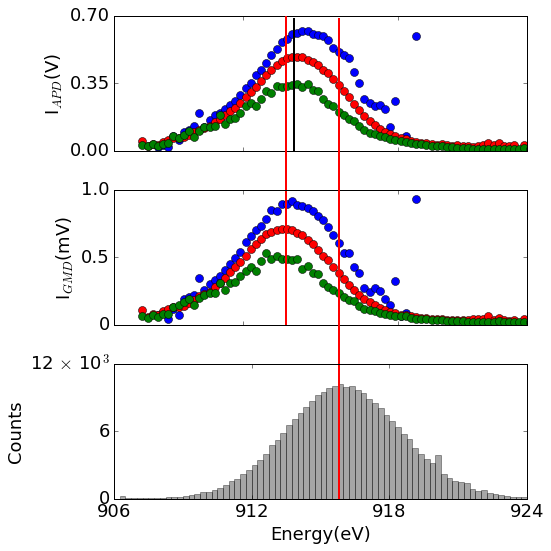

In [42]:
f, axarr = plt.subplots(3, sharex=True)

for i in [[.60,1],[.4,.56],[.0,.4]]:
    IvsFEE_average,I0vsFEE_average,e_bins = make_IvsI0(i[0],i[1],40,50)
    IvsE_moment = mean(nan_to_num(IvsFEE_average*e_bins[:-1]))/mean(nan_to_num(IvsFEE_average))
    I0vsE_moment = mean(nan_to_num(I0vsFEE_average*e_bins[:-1]))/mean(nan_to_num(I0vsFEE_average))
    axarr[0].plot(e_bins[:-1],IvsFEE_average,'o',markersize=8,alpha = 1.0)
    axarr[1].plot(e_bins[:-1],I0vsFEE_average,'o',markersize=8,alpha = 1.0)

energy_start_plot,energy_end_plot = 907,923
    
#axarr[0].set_xlabel("Energy(eV)")
axarr[0].set_ylabel("I$_{APD}$(V)")
axarr[0].set_xlim(energy_start_plot,energy_end_plot)
#axarr[0].axvline(x=IvsE_moment,color='r',linewidth=4)
axarr[0].axvline(x=IvsE_moment,color='k',linewidth=2,ymin=0,ymax=0.975,clip_on=False)
axarr[0].set_yticks(arange(0,0.71,0.7/2))
#axarr[0].set_yticklabels(["0","0.5","1.0"])

#axarr[1].set_xlabel("Energy(eV)")
axarr[1].set_ylabel("I$_{GMD}$(mV)")
axarr[1].set_xlim(energy_start_plot,energy_end_plot)
#axarr[1].axvline(x=I0vsE_moment,color='r',linewidth=4)
axarr[1].axvline(x=I0vsE_moment,color='r',linewidth=2,ymin=0,ymax=2.275,clip_on=False)
axarr[1].set_yticks(arange(0,0.0011,0.0005))
axarr[1].set_yticklabels(["0","0.5","1.0"])

axarr[2].hist(my_dict['ebeam/photon_energy'],bins= arange(905,925,.25),color='k',alpha=0.35)
my_hist = histogram(my_dict['ebeam/photon_energy'],bins= arange(905,925,.25))
#x_location = my_hist[1][argmax([my_hist[0]])]
x_location = mean(my_dict['ebeam/photon_energy'])
#axarr[2].axvline(x=x_location,color='r',linewidth=4)
axarr[2].axvline(x=x_location,color='r',linewidth=2,ymin=0,ymax=3.55,clip_on=False)

axarr[2].set_xlabel("Energy(eV)")
axarr[2].set_ylabel("Counts")

axarr[2].set_xlim(energy_start_plot,energy_end_plot)
axarr[2].set_xticks(arange(906,925,6))
axarr[2].set_xticklabels(["906","912","918","924"])


axarr[2].set_yticks(arange(0,12100,6000))
axarr[2].set_yticklabels(["0","6",r"12 $ \times $ 10$^3$"])
f.tight_layout()

show()

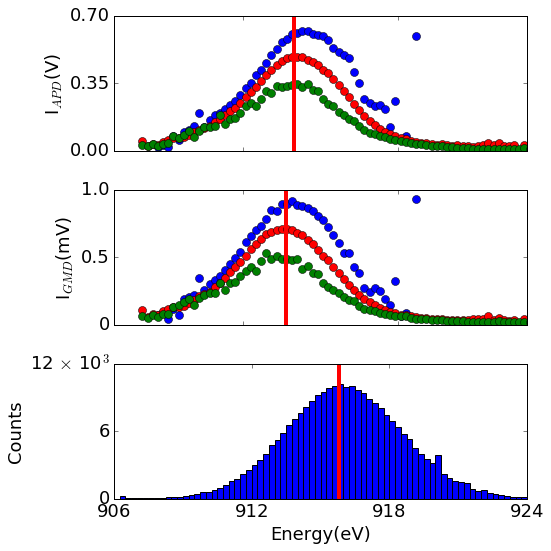

In [43]:
f, axarr = plt.subplots(3, sharex=True)

for i in [[.60,1],[.4,.56],[.0,.4]]:
    IvsFEE_average,I0vsFEE_average,e_bins = make_IvsI0(i[0],i[1],40,50)
    IvsE_moment = mean(nan_to_num(IvsFEE_average*e_bins[:-1]))/mean(nan_to_num(IvsFEE_average))
    I0vsE_moment = mean(nan_to_num(I0vsFEE_average*e_bins[:-1]))/mean(nan_to_num(I0vsFEE_average))
    axarr[0].plot(e_bins[:-1],IvsFEE_average,'o',markersize=8,alpha = 1.0)
    axarr[1].plot(e_bins[:-1],I0vsFEE_average,'o',markersize=8,alpha = 1.0)

energy_start_plot,energy_end_plot = 907,923
    
#axarr[0].set_xlabel("Energy(eV)")
axarr[0].set_ylabel("I$_{APD}$(V)")
axarr[0].set_xlim(energy_start_plot,energy_end_plot)
axarr[0].axvline(x=IvsE_moment,color='r',linewidth=4)
axarr[0].set_yticks(arange(0,0.71,0.7/2))
#axarr[0].set_yticklabels(["0","0.5","1.0"])

#axarr[1].set_xlabel("Energy(eV)")
axarr[1].set_ylabel("I$_{GMD}$(mV)")
axarr[1].set_xlim(energy_start_plot,energy_end_plot)
axarr[1].axvline(x=I0vsE_moment,color='r',linewidth=4)
axarr[1].set_yticks(arange(0,0.0011,0.0005))
axarr[1].set_yticklabels(["0","0.5","1.0"])

axarr[2].hist(my_dict['ebeam/photon_energy'],bins= arange(905,925,.25))
my_hist = histogram(my_dict['ebeam/photon_energy'],bins= arange(905,925,.25))
#x_location = my_hist[1][argmax([my_hist[0]])]
x_location = mean(my_dict['ebeam/photon_energy'])
axarr[2].axvline(x=x_location,color='r',linewidth=4)

axarr[2].set_xlabel("Energy(eV)")
axarr[2].set_ylabel("Counts")

axarr[2].set_xlim(energy_start_plot,energy_end_plot)
axarr[2].set_xticks(arange(906,925,6))
axarr[2].set_xticklabels(["906","912","918","924"])


axarr[2].set_yticks(arange(0,12100,6000))
axarr[2].set_yticklabels(["0","6",r"12 $ \times $ 10$^3$"])
f.tight_layout()

show()

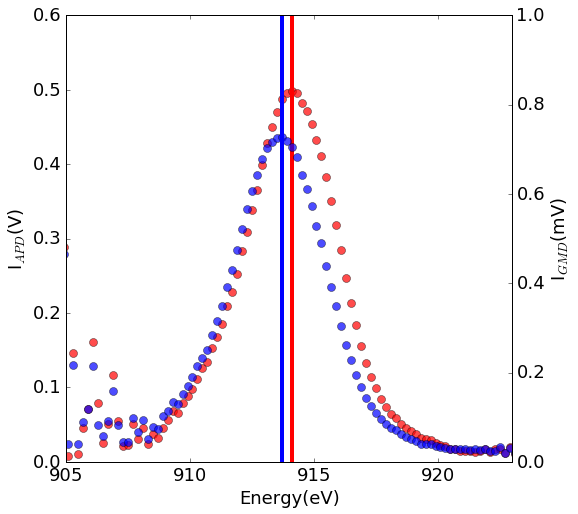

In [44]:
f3, axarr3 = plt.subplots(1, sharex=True)

IvsFEE_average,I0vsFEE_average,e_bins = make_IvsI0(.3,.6,0,20)
axarr3.plot(e_bins[:-1],IvsFEE_average,'o',markersize=8,alpha = 0.7,color='r')
axarr3.set_xlabel("Energy(eV)")
axarr3.set_ylim(0,0.6)
axarr3.set_ylabel("I$_{APD}$(V)")
x_location = e_bins[argmax(nan_to_num(IvsFEE_average))]
axarr3.axvline(x=x_location,color='r',linewidth=4)
axarr4 = axarr3.twinx()
axarr4.plot(e_bins[:-1],I0vsFEE_average,'o',markersize=8,alpha = 0.7)
axarr4.set_ylabel("I$_{GMD}}$(mV)")
axarr4.set_ylim(0,0.001)
axarr4.set_xlim(energy_start_plot-2,energy_end_plot)
axarr4.set_yticks(arange(0,.0011,.0002))
axarr4.set_yticklabels(["0.0","0.2","0.4","0.6","0.8","1.0"])
x2_location = e_bins[argmax(nan_to_num(I0vsFEE_average))]
axarr4.axvline(x=x2_location,color='b',linewidth=4)

show()

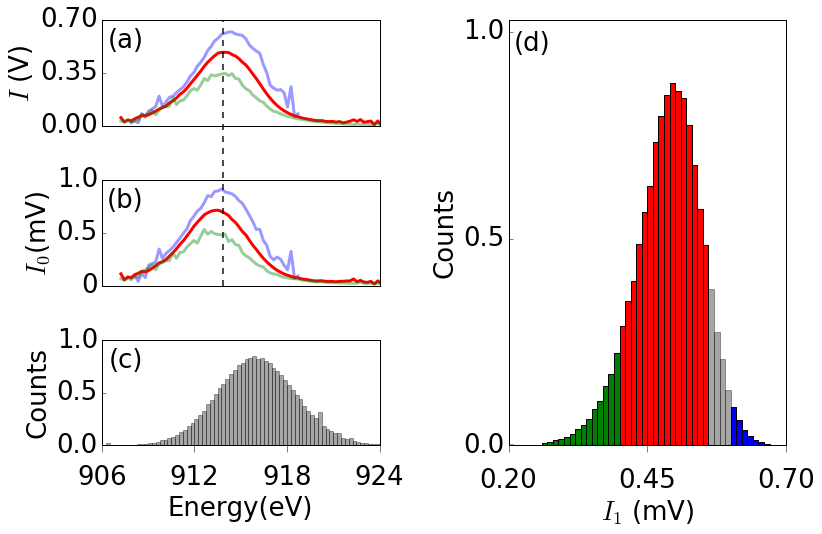

In [47]:
mpl.rcParams['figure.figsize'] = (12,8)
mpl.rcParams['font.size'] = 26
mpl.rcParams['legend.fontsize'] = 16

my_style = '-'

#f, axarr = plt.subplots(3, sharex=True)
axarr = [plt.subplot(321),plt.subplot(323),plt.subplot(325),plt.subplot(122)]

my_alpha  = [0.4,1.0,0.4]
counter =0
for i in [[.60,1],[.4,.56],[.0,.4]]:
    IvsFEE_average,I0vsFEE_average,e_bins = make_IvsI0(i[0],i[1],40,50)
    IvsE_moment = mean(nan_to_num(IvsFEE_average*e_bins[:-1]))/mean(nan_to_num(IvsFEE_average))
    I0vsE_moment = mean(nan_to_num(I0vsFEE_average*e_bins[:-1]))/mean(nan_to_num(I0vsFEE_average))
    axarr[0].plot(e_bins[:-1],IvsFEE_average,my_style,markersize=6,alpha = my_alpha[counter],linewidth=3)
    axarr[1].plot(e_bins[:-1],I0vsFEE_average,my_style,markersize=6,alpha =  my_alpha[counter],linewidth=3)
    counter += 1 
energy_start_plot,energy_end_plot = 907,923
x_label_offset = 0.15
y_label_offset = 0.925

#axarr[0].set_xlabel("Energy(eV)")
axarr[0].set_ylabel("$I$ (V)")
axarr[0].set_xlim(energy_start_plot,energy_end_plot)
#axarr[0].axvline(x=IvsE_moment,color='k',linewidth=4,alpha=0.5)
axarr[0].set_yticks(arange(0,0.71,0.7/2))
#axarr[0].set_yticklabels(["0","0.5","1.0"])
axarr[0].text(x_label_offset, y_label_offset, "(a)", transform=axarr[0].transAxes,fontsize=26, fontweight='normal', va='top', ha='right')
axarr[0].get_xaxis().set_ticks([])
axarr[0].yaxis.set_ticks_position('left')
axarr[0].xaxis.set_ticks_position('bottom')

#axarr[1].set_xlabel("Energy(eV)")
axarr[1].set_ylabel("$I_{0}$(mV)")
axarr[1].set_xlim(energy_start_plot,energy_end_plot)
#axarr[1].axvline(x=I0vsE_moment,color='k',linewidth=4,alpha=0.5)
axarr[1].axvline(x=IvsE_moment,color='k',linewidth=2,ymin=0,ymax=2.50,clip_on=False,alpha=0.7,linestyle='dashed')
axarr[1].set_yticks(arange(0,0.0011,0.0005))
axarr[1].set_yticklabels(["0","0.5","1.0"])
axarr[1].text(x_label_offset, y_label_offset, "(b)", transform=axarr[1].transAxes,fontsize=26, fontweight='normal', va='top', ha='right')
axarr[1].get_xaxis().set_ticks([])
axarr[1].yaxis.set_ticks_position('left')
axarr[1].xaxis.set_ticks_position('bottom')


axarr[2].hist(my_dict['ebeam/photon_energy'],bins= arange(905,925,.25),color='k',alpha=0.35)
my_hist = histogram(my_dict['ebeam/photon_energy'],bins= arange(905,925,.25))
#x_location = my_hist[1][argmax([my_hist[0]])]
x_location = mean(my_dict['ebeam/photon_energy'])
#axarr[2].axvline(x=x_location,color='r',linewidth=4)
#axarr[2].axvline(x=x_location,color='r',linewidth=2,ymin=0,ymax=3.2,clip_on=False)
axarr[2].text(x_label_offset, y_label_offset, "(c)", transform=axarr[2].transAxes,fontsize=26, fontweight='normal', va='top', ha='right')

axarr[2].set_xlabel("Energy(eV)")
axarr[2].set_ylabel("Counts")

axarr[2].set_xlim(energy_start_plot,energy_end_plot)
axarr[2].set_xticks(arange(906,925,6))
axarr[2].set_xticklabels(["906","912","918","924"])
axarr[2].tick_params(axis='x', pad=15)


axarr[2].set_yticks(arange(0,12100,6000))
axarr[2].set_ylim(0,12100)
#axarr[2].set_yticklabels(["0","6",r"12 $ \times $ 10$^3$"])
axarr[2].set_yticklabels(["0.0","0.5", "1.0"])
axarr[2].yaxis.set_ticks_position('left')
axarr[2].xaxis.set_ticks_position('bottom')
axarr[2].tick_params(axis='x', pad=15,direction = 'out',length=7)
f.tight_layout()

#show()

axarr[3] = plt.subplot(122)

axarr[3].hist(fee,bins=arange(0.2,0.7,0.01),color='k',alpha=0.35)
axarr[3].set_ylabel("Counts")
axarr[3].set_xlabel("$I_{1}$ (mV)")
axarr[3].text(x_label_offset, 0.975, "(d)", transform=axarr[3].transAxes,fontsize=26, fontweight='normal', va='top', ha='right')
axarr[3].set_ylim(0,14400)
axarr[3].set_yticks(arange(0,14400,7000))
axarr[3].set_yticklabels(["0.0","0.5", "1.0"])
axarr[3].set_xlim(0.2,0.7)
axarr[3].set_xticks(arange(0.2,0.71,0.25))
axarr[3].set_xticklabels(["0.20","0.45","0.70"])
axarr[3].tick_params(axis='x', pad=15,direction = 'out',length=7)
axarr[3].yaxis.set_ticks_position('left')
axarr[3].xaxis.set_ticks_position('bottom')

for i in [[.60,1],[.4,.56],[.0,.4]]:
    color_fee_mask = fee > i[0]
    color_fee_mask *= fee < i[1]
    axarr[3].hist(fee[color_fee_mask],bins=arange(0.2,0.7,0.01),alpha=1)

tight_layout()
show()

mpl.rcParams['figure.figsize'] = (8,8)
mpl.rcParams['font.size'] = 18
mpl.rcParams['legend.fontsize'] = 10

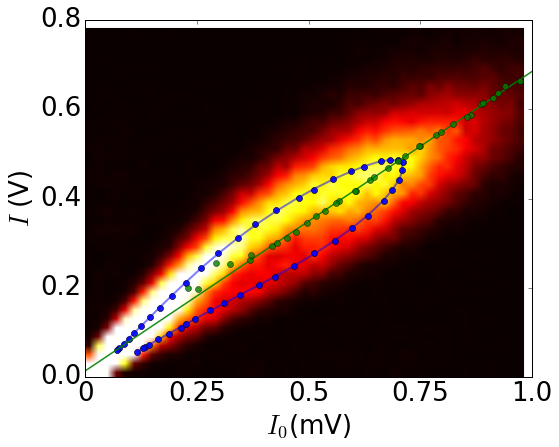

In [49]:
mpl.rcParams['font.size'] = 26

def gaussian(x, x0,sigma,a):
        
    #return a*exp(-(x-x0)**2/(2*sigma**2))+0.7e-4
    return a*exp(-(x-x0)**2/(2*sigma**2))

def gaussian_mod(offset):
    def gaussian(x, x0,sigma,a):
        return a*exp(-(x-x0)**2/(2*sigma**2))+offset
    return gaussian

my_colors = ['b','g','c']
fig, axes = plt.subplots(1, sharex=True)
axes.imshow((IvsI0_hist[0][::-1,:]+1),cmap='hot',interpolation='bilinear',clim=(0,400),extent=(0,max(x_bins),0,max(y_bins)),aspect=1.0/1e3)
####
#cax = axes.imshow((IvsI0_hist[0][::-1,:]+1),cmap='hot',interpolation='bilinear',clim=(0,400),extent=(0,max(x_bins),0,max(y_bins)),aspect=1.0/1e3)

#cbar = fig.colorbar(cax, ticks=[0, 200, 400])
#cbar.ax.set_yticklabels(['0', '200', '400'])  # vertically oriented colorbar
###########

#fig, (axes) = plt.subplots(ncols=1)

#img1 = axes.imshow(IvsI0_hist[0][::-1,:]+1)
#divider = make_axes_locatable(axes)
#cax1 = divider.append_axes("right", size="5%", pad=0.05)
#fig.colorbar(img1, cax=cax1)




ylabel("$I$ (V)")
xlabel("$I_{0}$(mV)")
my_counter = 0 
#for i in [[.60,1],[.4,.56],[.0,.4]]:
for i in [[.4,.56]]:
    IvsFEE_average,I0vsFEE_average,e_bins = make_IvsI0(i[0],i[1],45,82)
    axes.plot(I0vsFEE_average,IvsFEE_average,'o',markersize=6,alpha = 0.7,color=my_colors[my_counter])
    poptIvsFee, pcovIvsFee = curve_fit(gaussian, e_bins[:-1],IvsFEE_average,p0=[914,5,1])
    poptI0vsFee, pcovI0vsFee = curve_fit(gaussian, e_bins[:-1],I0vsFEE_average,p0=[914,5,.001])
    axes.plot(savgol_filter(I0vsFEE_average,11,3),savgol_filter(IvsFEE_average,11,3),alpha=0.5,linewidth=2,color=my_colors[my_counter])
    #poptIvsFee, pcovIvsFee = curve_fit(gaussian_mod(-0.00), e_bins[:-1],IvsFEE_average,p0=[914,5,1])
    #poptI0vsFee, pcovI0vsFee = curve_fit(gaussian_mod(-1e-5), e_bins[:-1],I0vsFEE_average,p0=[914,5,.001])
    #axes.plot(gaussian(e_bins,*poptI0vsFee),gaussian(e_bins,*poptIvsFee),alpha=0.5,linewidth=4,color=my_colors[my_counter])
    
    my_counter +=1
    
#test_data = array([I0vsFEE_average,IvsFEE_average])
#savetxt("test.dat",test_data)
#imported_data = loadtxt("test.dat")
axes.plot(I0vsFEE_average,IvsFEE_average,'o',markersize=6,alpha = 0.7,color='b')
#plot(imported_data[0],imported_data[1])
#show()

axes.plot(arange(0,0.0015,.0001),my_slope[0]*arange(0,0.0015,.0001)+my_slope[1],'g-',linewidth=1.5,alpha=0.9)
axes.plot(array(GMD_spectra_amplitude).transpose()[2],array(acq_spectra_amplitude).transpose()[2],'go',alpha=50)
axes.set_xlim(0,0.001)
axes.set_ylim(0,0.8)
axes.set_xticks(arange(0,0.0011,0.00025))
axes.set_xticklabels(["0","0.25","0.5","0.75","1.0"])
axes.set_yticks(arange(0,0.9,0.2))
show()

In [18]:
#####################
#####################
#####################
#####################
#####################
#####################

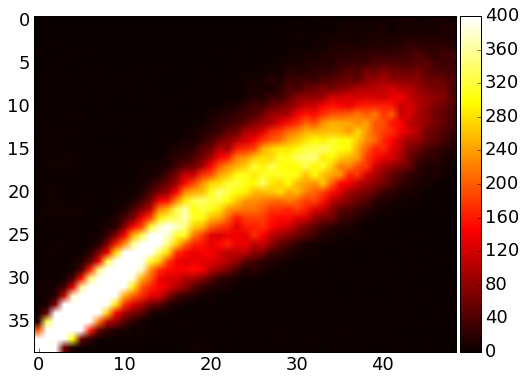

In [19]:
def gaussian(x, x0,sigma,a):
        
    #return a*exp(-(x-x0)**2/(2*sigma**2))+0.7e-4
    return a*exp(-(x-x0)**2/(2*sigma**2))

def gaussian_mod(offset):
    def gaussian(x, x0,sigma,a):
        return a*exp(-(x-x0)**2/(2*sigma**2))+offset
    return gaussian

my_colors = ['b','g','c']
#fig, axes = plt.subplots(1, sharex=True)
#axes.imshow((IvsI0_hist[0][::-1,:]+1),cmap='hot',interpolation='bilinear',clim=(0,400),extent=(0,max(x_bins),0,max(y_bins)),aspect=1.0/1e3)
####
#cax = axes.imshow((IvsI0_hist[0][::-1,:]+1),cmap='hot',interpolation='bilinear',clim=(0,400),extent=(0,max(x_bins),0,max(y_bins)),aspect=1.0/1e3)

#cbar = fig.colorbar(cax, ticks=[0, 200, 400])
#cbar.ax.set_yticklabels(['0', '200', '400'])  # vertically oriented colorbar
###########

fig, (axes) = plt.subplots(ncols=1)
#img1 = axes.imshow(IvsI0_hist[0][::-1,:]+1,cmap='hot',interpolation='bilinear',clim=(0,400),extent=(0,max(x_bins),0,max(y_bins)),aspect=1.0/1e3)
img1 = axes.imshow(IvsI0_hist[0][::-1,:]+1,cmap='hot',interpolation='bilinear',clim=(0,400))
####




"""
ylabel("I$_{APD}$(V)")
xlabel("I$_{GMD}$(mV)")
my_counter = 0 
#for i in [[.60,1],[.4,.56],[.0,.4]]:
for i in [[.4,.56]]:
    IvsFEE_average,I0vsFEE_average,e_bins = make_IvsI0(i[0],i[1],45,82)
    axes.plot(I0vsFEE_average,IvsFEE_average,'o',markersize=6,alpha = 0.7,color=my_colors[my_counter])
    poptIvsFee, pcovIvsFee = curve_fit(gaussian, e_bins[:-1],IvsFEE_average,p0=[914,5,1])
    poptI0vsFee, pcovI0vsFee = curve_fit(gaussian, e_bins[:-1],I0vsFEE_average,p0=[914,5,.001])
    axes.plot(savgol_filter(I0vsFEE_average,11,3),savgol_filter(IvsFEE_average,11,3),alpha=0.5,linewidth=2,color=my_colors[my_counter])
    #poptIvsFee, pcovIvsFee = curve_fit(gaussian_mod(-0.00), e_bins[:-1],IvsFEE_average,p0=[914,5,1])
    #poptI0vsFee, pcovI0vsFee = curve_fit(gaussian_mod(-1e-5), e_bins[:-1],I0vsFEE_average,p0=[914,5,.001])
    #axes.plot(gaussian(e_bins,*poptI0vsFee),gaussian(e_bins,*poptIvsFee),alpha=0.5,linewidth=4,color=my_colors[my_counter])
    
    my_counter +=1
    

axes.plot(I0vsFEE_average,IvsFEE_average,'o',markersize=6,alpha = 0.7,color='b')
#plot(imported_data[0],imported_data[1])
#show()

axes.plot(arange(0,0.0015,.0001),my_slope[0]*arange(0,0.0015,.0001)+my_slope[1],'g-',linewidth=1.5,alpha=0.9)
axes.plot(array(GMD_spectra_amplitude).transpose()[2],array(acq_spectra_amplitude).transpose()[2],'go',alpha=50)
#axes.set_xlim(0,0.001)
#axes.set_ylim(0,0.8)
#axes.set_xticks(arange(0,0.0011,0.00025))
#axes.set_xticklabels(["0","0.25","0.5","0.75","1.0"])
#axes.set_yticks(arange(0,0.9,0.2))
"""

divider = make_axes_locatable(axes)
cax1 = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(img1, cax=cax1)

show()

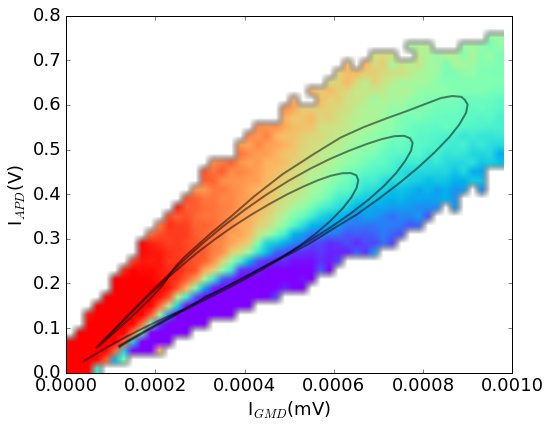

In [23]:
fee_mask = array(fee<0.8)
IvsI0_hist = binned_statistic_dd([y[fee_mask],x[fee_mask]],my_dict['ebeam/photon_energy'][my_mask][fee_mask],bins=[y_bins,x_bins],statistic='mean')
IvsI0_count = (binned_statistic_dd([y[fee_mask],x[fee_mask]],fee[fee_mask],bins=[y_bins,x_bins],statistic='count')[0]>10).astype(float)
IvsI0_count[IvsI0_count==False] = nan
IvsI0_count[IvsI0_count==True] = 1

#IvsI0_hist = binned_statistic_dd([y,x],my_dict['ebeam/photon_energy'][my_mask],bins=[y_bins,x_bins],statistic='mean')
#IvsI0_hist = binned_statistic_dd([y,x],fee,bins=[y_bins,x_bins],statistic='mean')
def gaussian(x, x0,sigma,a):
        
    #return a*exp(-(x-x0)**2/(2*sigma**2))+0.7e-4
    return a*exp(-(x-x0)**2/(2*sigma**2))

def gaussian_mod(offset):
    def gaussian(x, x0,sigma,a):
        return a*exp(-(x-x0)**2/(2*sigma**2))+offset
    return gaussian

my_colors = ['b','g','c']
axes = figure().add_subplot(111)
axes.imshow((((IvsI0_count*IvsI0_hist[0])[::-1,:])),cmap='rainbow',interpolation='bilinear',clim=(912,916.5),extent=(0,max(x_bins),0,max(y_bins)),aspect=1.0/1e3)
ylabel("I$_{APD}$(V)")
xlabel("I$_{GMD}$(mV)")
my_counter = 0 
#for i in [[.60,1],[.4,.56],[.0,.4]]:


for i in [[.60,0.8],[.5,.6],[.4,.5]]:
    IvsFEE_average,I0vsFEE_average,e_bins = make_IvsI0(i[0],i[1],45,82)
    #axes.plot(I0vsFEE_average,IvsFEE_average,'o',markersize=6,alpha = 0.7,color=my_colors[my_counter])
    poptIvsFee, pcovIvsFee = curve_fit(gaussian, e_bins[:-1],IvsFEE_average,p0=[914,5,1])
    poptI0vsFee, pcovI0vsFee = curve_fit(gaussian, e_bins[:-1],I0vsFEE_average,p0=[914,5,.001])
    axes.plot(savgol_filter(I0vsFEE_average,11,3),savgol_filter(IvsFEE_average,11,3),alpha=0.5,linewidth=2,color='k')
    #poptIvsFee, pcovIvsFee = curve_fit(gaussian_mod(-0.00), e_bins[:-1],IvsFEE_average,p0=[914,5,1])
    #poptI0vsFee, pcovI0vsFee = curve_fit(gaussian_mod(-1e-5), e_bins[:-1],I0vsFEE_average,p0=[914,5,.001])
    #axes.plot(gaussian(e_bins,*poptI0vsFee),gaussian(e_bins,*poptIvsFee),alpha=0.5,linewidth=4,color=my_colors[my_counter])
    
    my_counter +=1

#axes.plot(arange(0,0.0015,.0001),my_slope[0]*arange(0,0.0015,.0001)+my_slope[1],'k-',linewidth=1.5,alpha=0.7)
#axes.plot(array(GMD_spectra_amplitude).transpose()[2],array(acq_spectra_amplitude).transpose()[2],'ko',alpha=50)
#axes.set_xlim(0,0.001)
#axes.set_ylim(0,0.8)
#axes.set_xticks(arange(0,0.0011,0.00025))
#axes.set_xticklabels(["0","0.25","0.5","0.75","1.0"])
#axes.set_yticks(arange(0,0.9,0.2))
show()

/reg/g/psdm/sw/conda/inst/miniconda2-prod-rhel7/envs/ana-1.2.9-py3/lib/python3.5/site-packages/numpy/core/numeric.py:190: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  a = empty(shape, dtype, order)


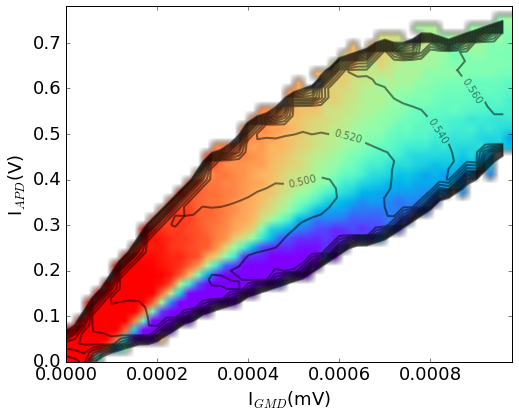

In [24]:
IvsI0_fee_hist = binned_statistic_dd([y[fee_mask],x[fee_mask]],fee[fee_mask],bins=[y_bins,x_bins],statistic='mean')
IvsI0_hist = binned_statistic_dd([y[fee_mask],x[fee_mask]],my_dict['ebeam/photon_energy'][my_mask][fee_mask],bins=[y_bins,x_bins],statistic='mean')
IvsI0_count = (binned_statistic_dd([y[fee_mask],x[fee_mask]],fee[fee_mask],bins=[y_bins,x_bins],statistic='count')[0]>10).astype(float)
IvsI0_count[IvsI0_count==False] = nan
IvsI0_count[IvsI0_count==True] = 1

y_mesh,x_mesh = meshgrid(IvsI0_fee_hist[1][0],IvsI0_fee_hist[1][1])

#cset1 = plt.contourf(X, Y, Z, levels,cmap=cm.get_cmap(cmap, len(levels) - 1), norm=norm)
k_size = 3.0
Z = scipy.ndimage.filters.convolve(nan_to_num((IvsI0_count*IvsI0_fee_hist[0])).transpose(), ones([k_size,k_size])/k_size**2)
levels = np.arange(0.3, 1.0, 0.02)
norm = cm.colors.Normalize(vmax=abs(Z).max(), vmin=-abs(Z).max())
cmap = cm.PRGn
#cset1 = plt.contour(x_mesh[:-1,:-1], y_mesh[:-1,:-1], Z, levels,cmap=cm.get_cmap(cmap, len(levels) - 1), norm=norm,linewidths=2)
axes = figure().add_subplot(111)
axes.imshow((((IvsI0_count*IvsI0_hist[0])[::-1,:])),cmap='rainbow',interpolation='bilinear',clim=(912,916.5),extent=(0,max(x_bins),0,max(y_bins)),aspect=1.0/1e3)
ylabel("I$_{APD}$(V)")
xlabel("I$_{GMD}$(mV)")

cset1 = plt.contour(x_mesh[:-1,:-1], y_mesh[:-1,:-1], Z, levels,colors='k', norm=norm,linewidths=2,alpha=0.5)

manual_locations = [(0.000525, 0.37), (0.0006, 0.45),(0.0008, 0.5),(0.0009, 0.6)]
plt.clabel(cset1, inline=1, fontsize=10, manual=manual_locations)
#cset1 = plt.contour(x_mesh[:-1,:-1], y_mesh[:-1,:-1], scipy.ndimage.zoom(Z,3), levels,colors='k', norm=norm,linewidths=2)
#axes.plot(savgol_filter(I0vsFEE_average,11,3),savgol_filter(IvsFEE_average,11,3),alpha=0.5,linewidth=2,color='k')
show()

In [25]:
fee_mask = array(fee<0.8)
fee_bins = arange(0.3,0.6,0.015)
IvsI0_hist = binned_statistic_dd([y[fee_mask],x[fee_mask]],fee[fee_mask],bins=[y_bins,x_bins],statistic='count')
IvsI0_count = (IvsI0_hist[0]>10).astype(float)
IvsI0_fee_hist = binned_statistic_dd([y[fee_mask],x[fee_mask]],fee[fee_mask],bins=[y_bins,x_bins],statistic='mean')
IvsI0_ebeam_hist = binned_statistic_dd([y[fee_mask],x[fee_mask]],my_dict['ebeam/photon_energy'][my_mask][fee_mask],bins=[y_bins,x_bins],statistic='mean')
#IvsI0_hist = binned_statistic_dd([y,x],my_dict['ebeam/photon_energy'][my_mask],bins=[y_bins,x_bins],statistic='mean')
#IvsI0_hist = binned_statistic_dd([y,x],fee,bins=[y_bins,x_bins],statistic='mean')


In [26]:
%matplotlib notebook

<IPython.core.display.Javascript object>


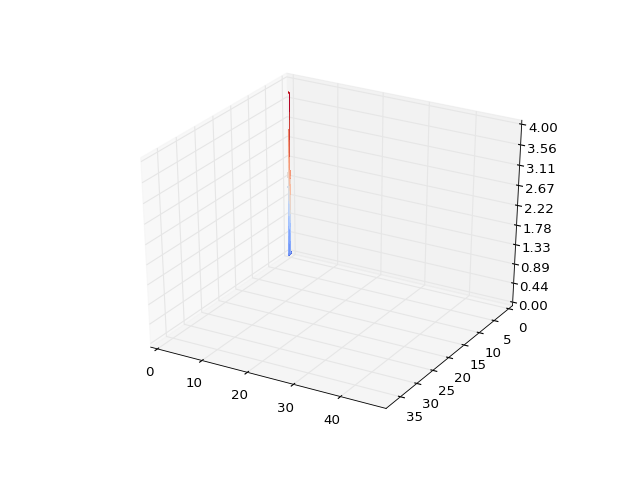

In [27]:
y_mesh,x_mesh = meshgrid(IvsI0_fee_hist[1][0],IvsI0_fee_hist[1][1])

fig = plt.figure()
ax = fig.gca(projection='3d')
#surf = ax.plot_surface(y_mesh[:-1,:-1], x_mesh[:-1,:-1], IvsI0_fee_hist[0].transpose(), cmap=cm.coolwarm,linewidth=0, antialiased=False)
#my_col = cm.jet(np.random.rand(IvsI0_ebeam_hist[0].transpose().shape[0],IvsI0_ebeam_hist[0].transpose().shape[1]))
IvsI0_ebeam_hist_norm = (nan_to_num(IvsI0_ebeam_hist[0])-908)
IvsI0_ebeam_hist_norm /= 12.0
my_col = cm.jet((IvsI0_ebeam_hist_norm*IvsI0_count).transpose())

#surf = ax.plot_surface(x_mesh[:-1,:-1], y_mesh[:-1,:-1], nan_to_num((IvsI0_count*IvsI0_fee_hist[0]).transpose()), rstride=1, cstride=1, facecolors = my_col,linewidth=0, antialiased=False)
#surf = ax.plot_surface(x_mesh[:-1,:-1], y_mesh[:-1,:-1], nan_to_num(IvsI0_hist[0]).transpose(), rstride=1, cstride=1, linewidth=0, antialiased=False)
surf = ax.plot_surface(x_mesh[:-1,:-1], y_mesh[:-1,:-1], log10(1+nan_to_num(IvsI0_hist[0]).transpose()),  rstride=1, cstride=1,cmap=cm.coolwarm,linewidth=0, antialiased=False)
ax.set_zlim(0, 4)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
show()

In [32]:
imshow(IvsI0_fee_hist[0][::-1])
show()

<IPython.core.display.Javascript object>


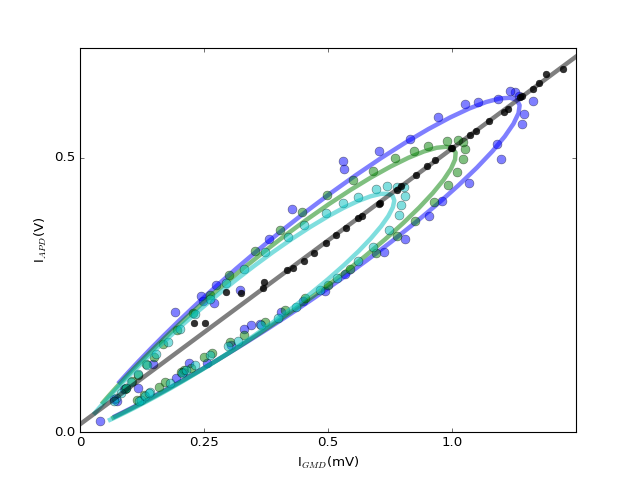

In [33]:
my_colors = ['b','g','c']
axes = figure().add_subplot(111)
#axes.imshow((IvsI0_hist[0][::-1,:]+1),cmap='hot',interpolation='bilinear',clim=(0,400),extent=(0,0.0012,0,1),aspect=1.0/1e3)
ylabel("I$_{APD}$(V)")
xlabel("I$_{GMD}$(mV)")
my_counter = 0 
#fee_bins = [[.60,1],[.5,.6],[.4,.5]]
fee_bins = [[.60,0.8],[.5,.6],[.4,.5]]
#fee_bins = array([arange(0.4,1,0.1),arange(0.4,1,0.1)+0.1]).transpose()
for i in fee_bins:
    IvsFEE_average,I0vsFEE_average,e_bins = make_IvsI0(i[0],i[1],45,82)
    axes.plot(I0vsFEE_average,IvsFEE_average,'o',markersize=8,alpha = 0.5,color=my_colors[my_counter])
    poptIvsFee, pcovIvsFee = curve_fit(gaussian, e_bins[:-1],IvsFEE_average,p0=[914,5,1])
    poptI0vsFee, pcovI0vsFee = curve_fit(gaussian, e_bins[:-1],I0vsFEE_average,p0=[914,5,.001])
    axes.plot(gaussian(e_bins,*poptI0vsFee),gaussian(e_bins,*poptIvsFee),alpha=0.5,linewidth=4,color=my_colors[my_counter])
    
    my_counter +=1

axes.plot(arange(0,0.0015,.0001),my_slope[0]*arange(0,0.0015,.0001)+my_slope[1],'k-',linewidth=4,alpha=0.5)
axes.plot(array(GMD_spectra_amplitude).transpose()[2],array(acq_spectra_amplitude).transpose()[2],'ko',alpha=50)
axes.set_xlim(0,0.001)
axes.set_xticks(arange(0,0.0011,0.00025))
axes.set_xticklabels(["0","0.25","0.5","1.0"])
axes.set_yticks(arange(0,1.1,0.5))
axes.set_ylim(0,.7)
show()

In [119]:
i

array([ 0.7,  0.8])

<IPython.core.display.Javascript object>


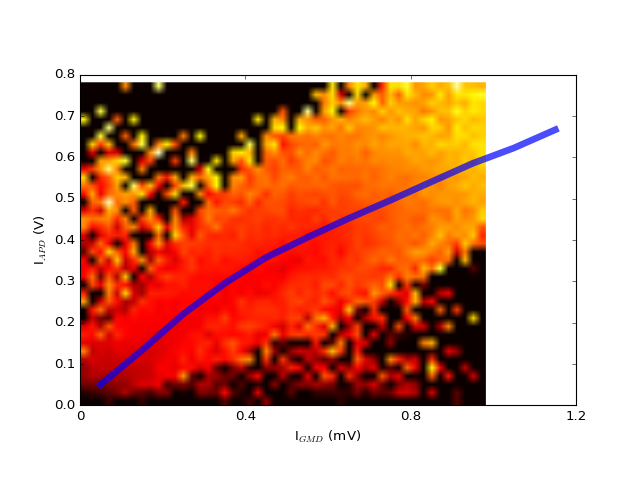

In [34]:
y_bins = arange(0,.8,0.02)
x_bins = arange(0,0.001,0.00002)
IvsI0_hist = binned_statistic_dd([y,x],fee,bins=[y_bins,x_bins],statistic='median')


my_hist = binned_statistic_dd(x,y,bins=[arange(0,0.0011,0.00005)],statistic=median).statistic
f2, axarr2 = plt.subplots(1, sharex=True)
axarr2.imshow((nan_to_num(IvsI0_hist[0][::-1,:]+1)),clim=(1.4,1.65),cmap='hot',interpolation='bilinear',extent=(0,max(x_bins),0,max(y_bins)),aspect=1.0/1e3)
axarr2.set_ylabel("I$_{APD}$ (V)")
axarr2.set_xlabel("I$_{GMD}}$ (mV)")

my_hist = binned_statistic_dd(x,y,bins=[arange(0,0.0014,0.0001)],statistic=mean).statistic
axarr2.plot((arange(0,0.0014,0.0001)[1:]+arange(0,0.0014,0.0001)[:-1])/2,my_hist,linewidth=6,alpha=0.7)
#plot(array(GMD_spectra_amplitude).transpose()[2],array(acq_spectra_amplitude).transpose()[2],'go')

#plot(arange(0,0.0011,0.00005)[:-1],my_hist,'b-',marker='o',linewidth=1)
axarr2.set_xlim(0,0.0012)
axarr2.set_xticks(arange(0,0.0014,0.0004))
axarr2.set_xticklabels(["0","0.4","0.8","1.2"])

#xlabel()
show()


In [35]:
%matplotlib notebook

<IPython.core.display.Javascript object>


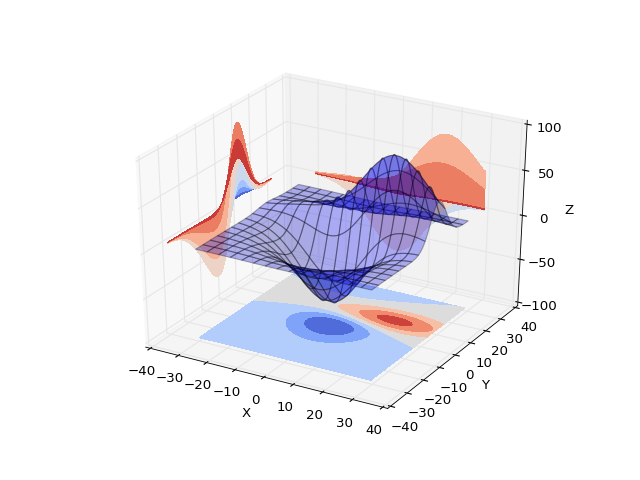

In [36]:
"""
.. versionadded:: 1.1.0
   This demo depends on new features added to contourf3d.
"""

from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
from matplotlib import cm

fig = plt.figure()
ax = fig.gca(projection='3d')
X, Y, Z = axes3d.get_test_data(0.05)
ax.plot_surface(X, Y, Z, rstride=8, cstride=8, alpha=0.3)
cset = ax.contourf(X, Y, Z, zdir='z', offset=-100, cmap=cm.coolwarm)
cset = ax.contourf(X, Y, Z, zdir='x', offset=-40, cmap=cm.coolwarm)
cset = ax.contourf(X, Y, Z, zdir='y', offset=40, cmap=cm.coolwarm)

ax.set_xlabel('X')
ax.set_xlim(-40, 40)
ax.set_ylabel('Y')
ax.set_ylim(-40, 40)
ax.set_zlabel('Z')
ax.set_zlim(-100, 100)

plt.show()

In [291]:
IvsEBeam_hist = binned_statistic_dd([x[fee_mask],energy[fee_mask]],fee[fee_mask],bins=[x_bins,e_bins],statistic='mean')

<IPython.core.display.Javascript object>


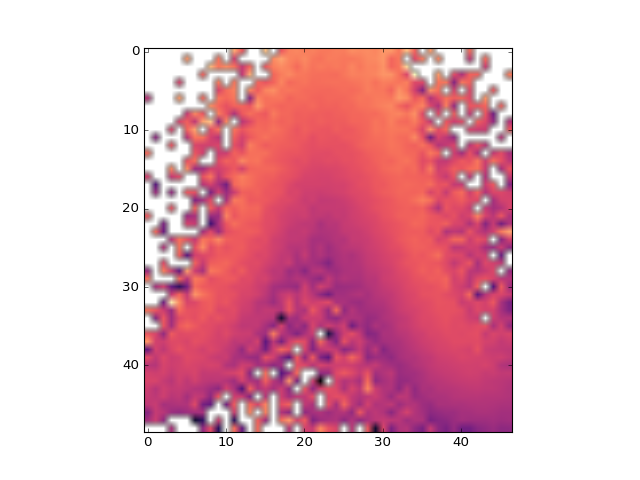

In [294]:
f2, axarr2 = plt.subplots(1, sharex=True)
axarr2.imshow(IvsEBeam_hist[0][::-1])
#axarr2.imshow((nan_to_num(IvsI0_hist[0][::-1,:]+1)),clim=(1.3,1000.65),cmap='hot',extent=(0,max(x_bins),0,max(y_bins)),aspect=1.0/1e3)
show()

<IPython.core.display.Javascript object>


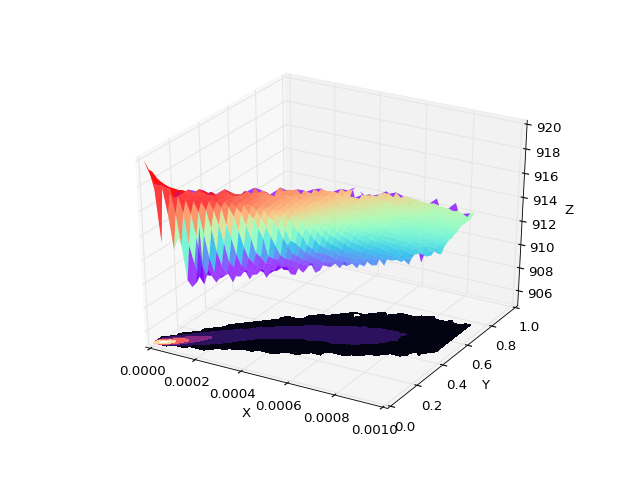

In [298]:
IvsI0_fee_hist = binned_statistic_dd([y[fee_mask],x[fee_mask]],fee[fee_mask],bins=[y_bins,x_bins],statistic='mean')
IvsI0_hist = binned_statistic_dd([y[fee_mask],x[fee_mask]],my_dict['ebeam/photon_energy'][my_mask][fee_mask],bins=[y_bins,x_bins],statistic='mean')
IvsI0_count = (binned_statistic_dd([y[fee_mask],x[fee_mask]],fee[fee_mask],bins=[y_bins,x_bins],statistic='count')[0])
nan_mask = ones(IvsI0_count.shape)
nan_mask[IvsI0_count<10]=nan
y_mesh,x_mesh = meshgrid(IvsI0_fee_hist[1][0],IvsI0_fee_hist[1][1])
"""
.. versionadded:: 1.1.0
   This demo depends on new features added to contourf3d.
"""

from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
from matplotlib import cm

fig = plt.figure()
ax = fig.gca(projection='3d')
#X, Y, Z = axes3d.get_test_data(0.05)
X,Y,Z1 = x_mesh[:-1,:-1][:,::-1],y_mesh[:-1,:-1][:,::-1],(nan_mask*IvsI0_count)[::-1,:].transpose(),
Z2 = (nan_mask*IvsI0_hist[0])[::-1,:].transpose()
Z3 = IvsI0_fee_hist[0].transpose()
cset = ax.contourf(X, Y, Z1, zdir='z', offset=905, cmap=cm.magma,levels=[0,200,800,1500,2500,3000])
#cset = ax.contourf(X, Y, Z3, zdir='x', offset=0, map=cm.rainbow)
#IvsFEE_average,I0vsFEE_average,e_bins
#cset = ax.plot(IvsFEE_average,e_bins[:-1],zeros(I0vsFEE_average.shape[0])*1e-3,zdir='x')
#cset = ax.plot(I0vsFEE_average,e_bins[:-1],zeros(I0vsFEE_average.shape[0]) ,zdir='y')
ax.plot_surface(X, Y, Z2, rstride=1, cstride=1, alpha=.5,linewidth = 0,cmap=cm.rainbow,vmin=912,vmax=916.5)
#cset = ax.contourf(X, Y, Z, zdir='y', offset=1, cmap=cm.coolwarm)
ax.plot_surface(X, Y, Z2, rstride=1, cstride=1, alpha=.5,linewidth = 0,cmap=cm.rainbow,vmin=912,vmax=916.5)

ax.set_xlabel('X')
ax.set_xlim(0, 1e-3)
ax.set_ylabel('Y')
ax.set_ylim(0, 1)
ax.set_zlabel('Z')
ax.set_zlim(905, 920)

plt.show()

<IPython.core.display.Javascript object>


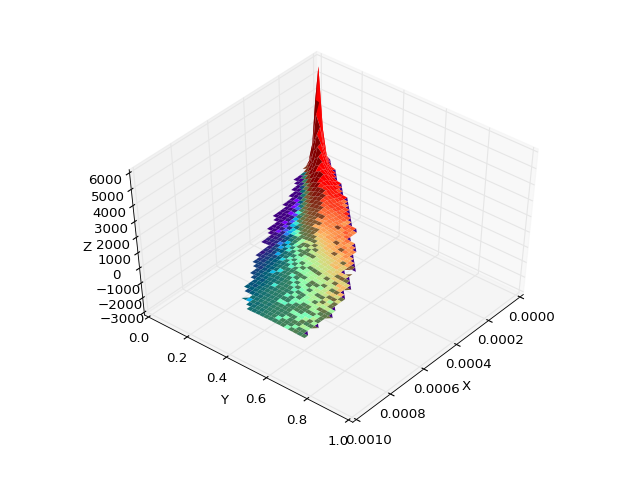

/reg/g/psdm/sw/conda/inst/miniconda2-prod-rhel7/envs/ana-1.2.9-py3/lib/python3.5/site-packages/matplotlib/colors.py:581: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


In [217]:
IvsI0_fee_hist = binned_statistic_dd([y[fee_mask],x[fee_mask]],fee[fee_mask],bins=[y_bins,x_bins],statistic='mean')
IvsI0_hist = binned_statistic_dd([y[fee_mask],x[fee_mask]],my_dict['ebeam/photon_energy'][my_mask][fee_mask],bins=[y_bins,x_bins],statistic='mean')
IvsI0_count = (binned_statistic_dd([y[fee_mask],x[fee_mask]],fee[fee_mask],bins=[y_bins,x_bins],statistic='count')[0])
nan_mask = ones(IvsI0_count.shape)
nan_mask[IvsI0_count<10]=nan
y_mesh,x_mesh = meshgrid(IvsI0_fee_hist[1][0],IvsI0_fee_hist[1][1])
"""
.. versionadded:: 1.1.0
   This demo depends on new features added to contourf3d.
"""

from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
from matplotlib import cm

fig = plt.figure()
ax = fig.gca(projection='3d')
#X, Y, Z = axes3d.get_test_data(0.05)
X,Y,Z1 = x_mesh[:-1,:-1][:,::-1],y_mesh[:-1,:-1][:,::-1],(nan_mask*IvsI0_count)[::-1,:].transpose(),
Z2 = (nan_mask*IvsI0_hist[0])[::-1,:].transpose()
Z3 = IvsI0_fee_hist[0].transpose()
#cset = ax.contourf(X, Y, Z1, zdir='z', offset=-2000, cmap=cm.magma,levels=[0,200,800,1500,2500,3000])
#cset = ax.contourf(X, Y, Z2, zdir='x', offset=0, map=cm.rainbow)
ax.plot_surface(X, Y, Z1, rstride=1, cstride=1, alpha=1,linewidth = 0,facecolors=plt.cm.rainbow((Z2*1.0-912/1.0)/4.5))
#cset = ax.contourf(X, Y, Z, zdir='y', offset=1, cmap=cm.coolwarm)

ax.set_xlabel('X')
ax.set_xlim(0, 1e-3)
ax.set_ylabel('Y')
ax.set_ylim(0, 1)
ax.set_zlabel('Z')
ax.set_zlim(-3000, 6000)

plt.show()

In [242]:
ax.plot?